<a href="https://colab.research.google.com/github/6862-2021SP-team3/pytorch-normalizing-flows/blob/master/nflib1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Copy code into CoLab space
!git clone https://github.com/6862-2021SP-team3/pytorch-normalizing-flows.git

fatal: destination path 'pytorch-normalizing-flows' already exists and is not an empty directory.


In [2]:
#Copy training data from online repository
!wget -O pi0.pkl https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0

--2021-04-11 23:51:39--  https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hrdhr5o1khtclmy/pi0.pkl [following]
--2021-04-11 23:51:40--  https://www.dropbox.com/s/raw/hrdhr5o1khtclmy/pi0.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc01fa0307518e44b00fc00014e5.dl.dropboxusercontent.com/cd/0/inline/BMeECTVItJGaGmw4ZK21hPl9YfXovREjMMND9hoP-hLZO_21wNOYSOQBbc9t0peCw8bMvlyf6NnrAqri5TvPfjUrs7bdT0Ho2_ztkp-kG4oT1bhoEDvcF37v6W9rEGhBevqCoVHYtgDfO6v-XzOQc5q3/file# [following]
--2021-04-11 23:51:40--  https://uc01fa0307518e44b00fc00014e5.dl.dropboxusercontent.com/cd/0/inline/BMeECTVItJGaGmw4ZK21hPl9YfXovREjMMND9hoP-hLZO_21wNOYSOQBbc9t0peCw8bMvlyf6NnrAqri5TvPfjUrs7bdT0Ho2_zt

In [3]:
#Install module needed to unpack the downloaded data
!pip3 install pickle5
import pickle5 as pickle

In [4]:
#Add local modules to path
import sys
sys.path.insert(0,'/content/pytorch-normalizing-flows')


In [5]:
#Standard import statements
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from datetime import datetime

#Pytorch imports
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

#NFlow library imports
from nflib.flows import (
    AffineConstantFlow, AffineHalfFlow, MLP, 
    NormalizingFlow, NormalizingFlowModel,
)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [6]:
#Create data class
class dataXZ:
  """
  read the data stored in pickle format
  the converting routine is at https://github.com/6862-2021SP-team3/hipo2pickle
  """
  def __init__(self):
    with open('pi0.pkl', 'rb') as f:
        xz = np.array(pickle.load(f), dtype=np.float32)
        xz = xz[:, 1:]
        x = xz[:, :16]
        z = xz[:, 16:]
        xwithoutPid = x[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        zwithoutPid = z[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        self.xz = xz
        self.x = torch.from_numpy(np.array(x))
        self.z = torch.from_numpy(np.array(z))
        self.xwithoutPid = torch.from_numpy(xwithoutPid)
        self.zwithoutPid = torch.from_numpy(zwithoutPid)

  def sample(self, n):
        randint = np.random.randint( self.xz.shape[0], size =n)
        xz = self.xz[randint]
        x = self.x[randint]
        z = self.z[randint]
        xwithoutPid = self.xwithoutPid[randint]
        zwithoutPid = self.zwithoutPid[randint]
        return {"xz":xz, "x": x, "z": z, "xwithoutPid": xwithoutPid, "zwithoutPid": zwithoutPid}

In [7]:
xz = dataXZ()
z = xz.z
x = xz.x



findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


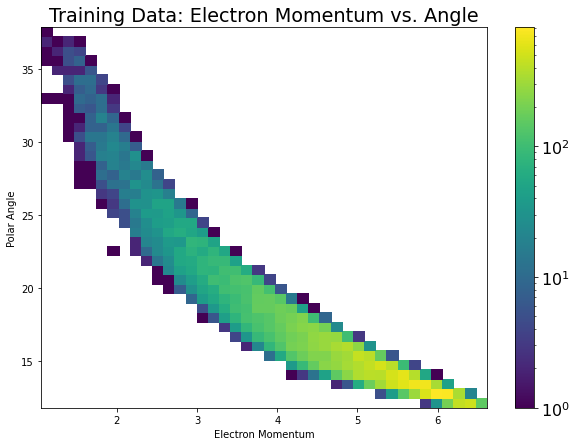

In [8]:
#Let's look at the data
sampleDict = xz.sample(30000) #Get a subset of the datapoints
x = sampleDict["xwithoutPid"][:, 0:2] #For now, only 
#print(x)
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"

ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.title('Training Data: Electron Momentum vs. Angle')
x= x.detach().numpy()

plt.hist2d(x[:,0], x[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()

In [9]:
sampleDict = xz.sample(100)
print(sampleDict["xz"][0])
print(sampleDict["xwithoutPid"][0])


[   6.2235456    12.396061    113.68551       1.            0.47303948
   37.49733    -119.81883       2.            2.8072138    17.186005
  -55.34054       3.            1.4111578    13.402449    -52.62216
    3.            6.2240944    12.436772    113.5609        1.
    0.56011856   33.79896    -115.5242        2.            2.7785654
   17.263416    -55.55515       3.            1.4430684    13.475644
  -52.71641       3.        ]
tensor([   6.2235,   12.3961,  113.6855,    0.4730,   37.4973, -119.8188,
           2.8072,   17.1860,  -55.3405,    1.4112,   13.4024,  -52.6222])


In [10]:
# construct a model
# try with electron momentum magintude and polar angle only
#prior = MultivariateNormal(torch.zeros(2), torch.eye(2)) # Normal distribution
prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv) # Logistic distribution
# NICE
flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(12)]
#print(flows)
flows.append(AffineConstantFlow(dim=2, shift=False))
#print(flows)


# construct the model
model = NormalizingFlowModel(prior, flows)

In [11]:
# optimizer
#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-9) # this one was pretty good, but oscillates
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-9) # pretty solid, two bands
#optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-10) # weird tail at high electron momenutm
#optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-9) # 


print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  15278


In [12]:
model.train()
start_now = datetime.now()
start_time = start_now.strftime("%H:%M:%S")
print("Start Time =", start_time)
losses = []
for k in range(5000):
    sampleDict = xz.sample(1000)
    x = sampleDict["xwithoutPid"][:, 0:2] # try with electron momentum magintude and polar angle only.
    
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if k % 100 == 0:
        run_time = datetime.now()
        elapsedTime = (run_time - start_now )
        print("On step {} - loss {:.2f}, Current Running Time = {:.2f} seconds".format(k,loss.item(),elapsedTime.total_seconds())) 

now = datetime.now()
end_time = now.strftime("%H:%M:%S")
print("End Time =", end_time)
elapsedTime = (now - start_now )
print("Total Run Time = {:.5f} seconds".format(elapsedTime.total_seconds()))




Start Time = 23:51:57
On step 0 - loss 27544.52, Current Running Time = 0.05 seconds
On step 100 - loss 8573.88, Current Running Time = 1.97 seconds
On step 200 - loss 3240.45, Current Running Time = 3.81 seconds
On step 300 - loss 3173.24, Current Running Time = 5.65 seconds
On step 400 - loss 3154.78, Current Running Time = 7.66 seconds
On step 500 - loss 3110.56, Current Running Time = 9.57 seconds
On step 600 - loss 3118.88, Current Running Time = 11.42 seconds
On step 700 - loss 3090.64, Current Running Time = 13.27 seconds
On step 800 - loss 3076.18, Current Running Time = 15.11 seconds
On step 900 - loss 3067.53, Current Running Time = 16.97 seconds
On step 1000 - loss 2979.78, Current Running Time = 18.80 seconds
On step 1100 - loss 3022.38, Current Running Time = 20.63 seconds
On step 1200 - loss 2983.23, Current Running Time = 22.49 seconds
On step 1300 - loss 3003.41, Current Running Time = 24.36 seconds
On step 1400 - loss 2979.04, Current Running Time = 26.20 seconds
On st

Text(0, 0.5, 'Loss')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


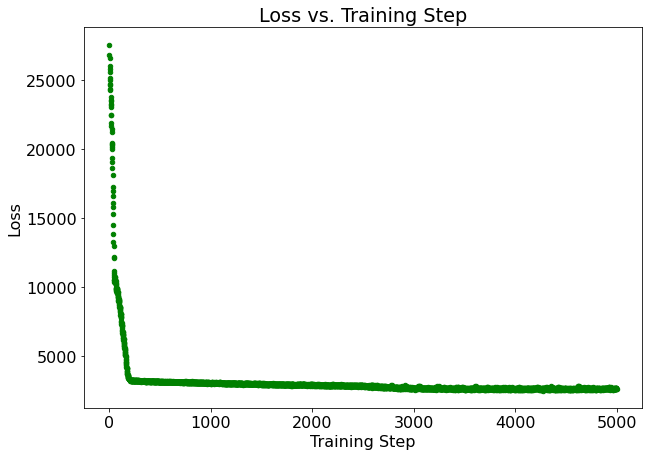

In [13]:
fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"

plt.scatter(np.arange(len(losses)),losses, c='g', s=20)
plt.title('Loss vs. Training Step')
ax.set_xlabel("Training Step")  
ax.set_ylabel("Loss")

tensor([ 5.6626, 13.0510])


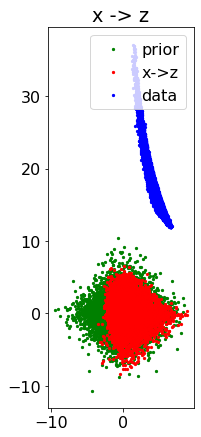

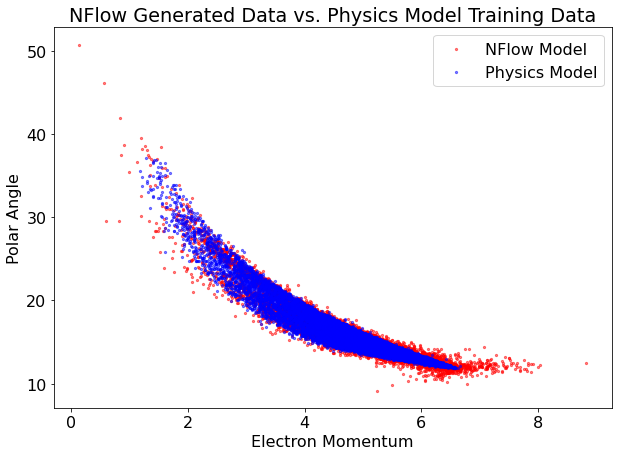

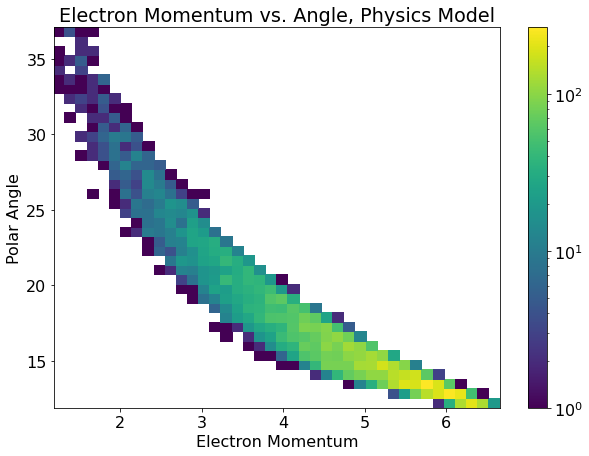

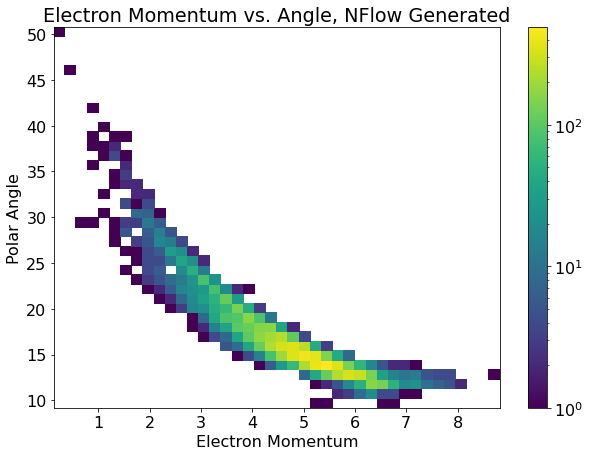

In [14]:
model.eval()
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"

sampleDict = xz.sample(10000)
x = sampleDict["xwithoutPid"][:, 0:2]
print(x[0])
zs, prior_logprob, log_det = model(x)
z = zs[-1]

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([10000, 2]).squeeze()
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')


zs = model.sample(10000)
z = zs[-1]
z = z.detach().numpy()
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.legend(['NFlow Model','Physics Model'])
plt.title('NFlow Generated Data vs. Physics Model Training Data')
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")

fig, ax = plt.subplots(figsize =(10, 7)) 
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.title('Electron Momentum vs. Angle, Physics Model')
plt.hist2d(x[:,0], x[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()


fig, ax = plt.subplots(figsize =(10, 7)) 
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
plt.title('Electron Momentum vs. Angle, NFlow Generated')
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.hist2d(z[:,0], z[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()